# Kaggle Competition: Uc3m Machine Learning Challenge

- **David Campos Brandao**: 
   - github: dcamposb 
   - email: davidcamposbrandao@gmail.com 

### Information about the Project (Context & Credit)
This is a notebook detailing the code used for a Kaggle Competition I participated in 2019. The competition was created by our Machine Learning professor: Dr. Pablo Martinez Olmos (a professor for the Masters in Big Data Analytics at Universidad Carllos III in Madrid).

In the original submission I ranked 25th in the 70 competitor pool. I am revisiting the code and **updating it for my github repository**. I am also making changes as I see fit, to improve the code with things I have learned since then. I will post the new ranking.

I collaborated with **Yolanda Ibañez Perez** for the original competition as a teammate. She is also responsible for the first iteration of said code in 2019. I have modified the code significantly, but the steps taken in each of this code blocks were discussed with her, so the logic and steps taken to find the optimal models for each target are a result of her work too. 

In therms of python code, Guillermo Peribañez and Alvaro Robledo were competing teammates, but helped us out so we could have clean and efficient code. Howerever, I have now significantly changed the code that they helped us write backin 2019. In any case, special thanks to my friends: @Mugen94, Yolanda and @periba, for all the good times and long hours doing projects like this during our Master's Degree.

Check out their profiles: 
- **Guillermo Peribañez Juan**: 
    - Github: https://github.com/periba
    - Linkedin: https://www.linkedin.com/in/peribanez/
- **Alvaro Robledo Quintero** : 
    - Github: https://github.com/Mugen94
    - Linkedin: https://www.linkedin.com/in/alvaro-robledo-quintero-578180122/
- **Yolanda Ibañez Perez** 
    - Linkedin: https://www.linkedin.com/in/yolanda-ib%C3%A1%C3%B1ez-p%C3%A9rez-3ab648135/

# Objetives: 

We are presented with a dataset with 800 variables and 14 target variables, with a training and a submission set to predict on.  We are given no information about the features, and the titles for them are nonexplanatory. The targets are non explanatory too. 

All we are indicated in this project is to get the **best score** in the competition, this is done by maximizing model acurracy submission. 

#### In order to do this, we must choose:
- A. the best model algorithm, 
- B. a set of optimal hyperparameters, 
- C. and a list of optimal features for each target variable

#### Justification 
Why?: One target variable which you are trying to predict for can be very different to another target variable. Let's say one is the amount of people who vote Republicans and the other one is the amount of people who are likely to buy an online offer when presented to them. Their might be a correlation between the targets (or perhaps not); the point some features/variables could give us more information to precict the first target (voting republican) and others can help us predict the second target. 

Also, a different algorithm can help predict a particular target, SVM is great to create boundaries between datapoints, while LR could be beter for a identifying association relationships between regressors and responses, and hence predict a relationship for continous instances. 

#### Steps Taken in this Project: 
1. Understanding Some Relationships between Variables and Targets
2. Eliminating any variables that could represent a Bias for the Model 
    - Meaning: variables that could make us overestimate the model's performance
3. Observing the Behaviour of our Target Variables 
    - to identify model opportunities 
4. Reducing Dimensions 
    - (Eliminating any unneccessary variables in our data sample)
5. Imputing Missing Data Points 
6. Scaling Data Points 
7. Training 5 Different Model Types  and 
8. Selecting the best Hyperparameter 
    - set for each prediction 
9. Comparing each algorithm performance 
    - for each target variable 
10. Choose the optimal "Algorithm/Feature/HyperParameter Set" 
    - to Predict on each Target 
11. Score the Unlabeled Dataset 
    - Predicting ove the (New Information set) for submission*

There will be a small explanation for each decision and step taken in this notebook, under the title and subtitles sections respectively.

# Project Starts Here:
### Import Modules 
Since we are working on jupyter notebooks for this project, one must check that the miniconda environment in which the notebook is being called, has the apporpiate packages downloaded. 



In [1]:
# Data Proccesing 
import pandas as pd 
import numpy as np 

# Sklearn Imports for Machine Learning 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns 

## Data Exploration

In the following section I will take a look at the presented data. Machine Learning can be reduced to simply training and validating; and subsequently selecting the best model with the best score, but data exploration is necessary to guarantee the *best* results. 

Understanding bias, distributions and feature relationships allows us to provide better interpretations  and data pipelines. 

In [141]:
# The professor for the class provided us with the data located in the Data Folder 
train = pd.read_csv("data/TrainData.csv")
score = pd.read_csv("data/TestData_unlabeled.csv")

In [142]:
# Features and Targets 
master_training = train[[T for T in train.columns if "Feat" in T ]]
master_target = train[[F for F in train.columns if "Class" in F]]
score_target  = score.iloc[:,1:] 

# Reducing Data Size ** 
# The origina dataset was 1500 
#master_training = master_training[:500]
#master_target = master_target[:500]

### Correlation Analysis 
In this section I will evaluate correlations between features and correlation with targets. 
- There might be features that are correlated to each other, and there is an opportunity to dropp some features and reduce our learning sample. 
- There is also a posibility that the targets are correlated between themselves. This would be interestedto see, as a model could fit best for certain targets. 
- And finally there could be a **direct correlation between a target and a feature**, which could be a **bias** for a model that is to be tested with unseen targets in the competition. This could cause drops in testing accuracy

### Feature Correlations 
For the following section we are trying to understand if their is a correlation between features. Meaning it two features have large correlations, what is the need to have both of them in the training sample. 

Let us say one of the features is simply 85% correlated to other 5. This could be because one if a transformation of the others, since our data sample is so big, reducing this features will allow us to have the same probable performance, with less features to manage. 

In the codeblock bellow I created a function called **drop_corr_cols**, it drops columns in your dataset that are too highly correlated, above a specified threshold.  

I also created a heatmap to show the relationship between the feature variables, I am interested in eliminating anything that has a correlation above 51%. 

*I am looking out to reduce as much variables as possible (this is not recommended, but my experience as Data Scientist has shown me that no model needs more than 300 features to predict efficiently)*

The Training sample was reduced from 803 columns to 803 columns, taking into consideration correlations


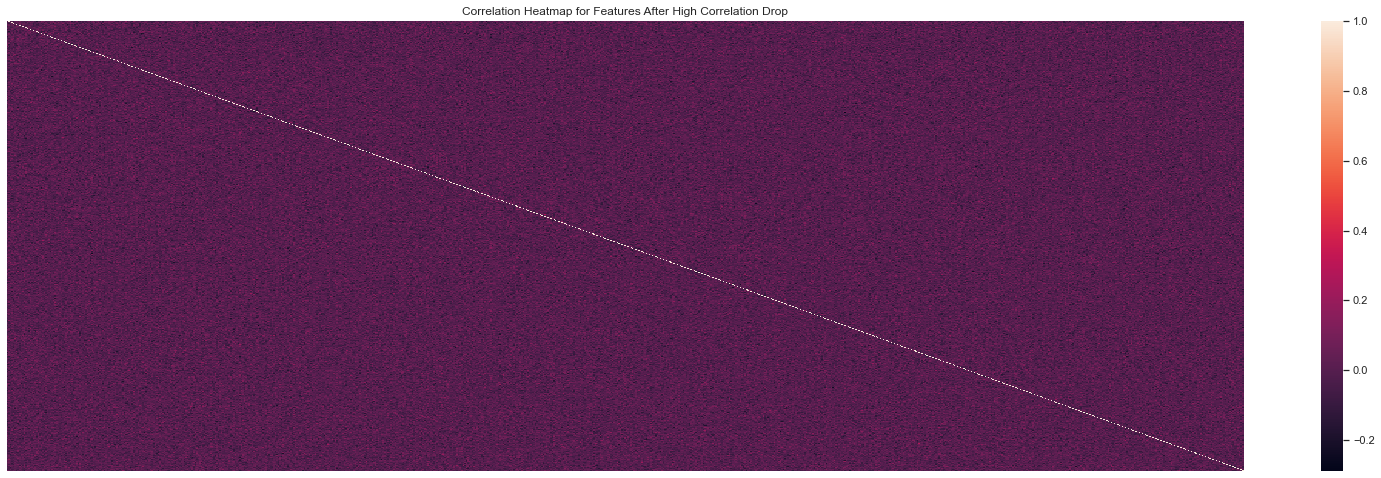

In [143]:
# Feature Correlation 
# Getting a Correlation Matrix 
# Dropping Features that are highly correlated to each Other 
def drop_corr_cols(master_training, threshold):
    """
    Function takes in a table and returns a table with the columns that are less correlated than 
    a given particular threshold. 
    
    It takes the table and a specified threshold as parameters.
    Returns a table with dropped columns that are too correlated. 
    """
    corr_matrix = master_training.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    return  master_training.drop(master_training[to_drop], axis=1)



# Dropping Columns with Correlation Higher than 0.51 (51% correlation)
training_correlation_dropped = drop_corr_cols(master_training, 0.51) # anything above 5% correlation is dropped 
sns.heatmap(training_correlation_dropped.corr(), annot = False, xticklabels= False ,yticklabels = False).set_title("Correlation Heatmap for Features After High Correlation Drop")
sns.set(rc={'figure.figsize':(11.7,8.27)})
print(f"The Training sample was reduced from {master_training.shape[1]} columns to {training_correlation_dropped.shape[1]} columns, taking into consideration correlations")

As the console print indicated: The Training sample was reduced from 803 columns to 803 columns, taking into consideration correlations; meaning no features were dropped. 

###  Target Correlations 

Lets take a look at correlation between the targets themselves. This allows me to see the relationship between the targets, let us say if a target is similar to another target variable. 

This could clue us on which model is best for which set of targets. I am going to use a heat map to represent that correlation relationship between the target variables. 

Text(0.5, 1.0, 'Correlation Heatmap for Targets Variables')

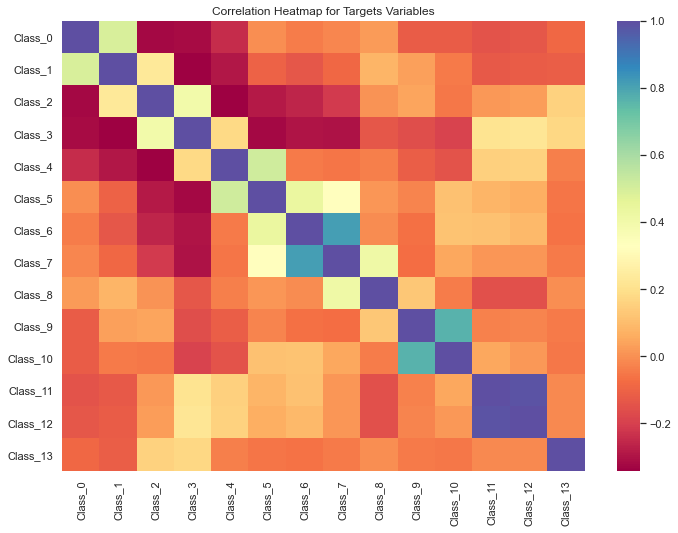

In [144]:
# Correlation Matrix for Target Columns 
master_target_corr = master_target.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(master_target_corr,  cmap="Spectral").set_title("Correlation Heatmap for Targets Variables")

**Quick observations**:
- One can see that target class 0 is negative correlated to a 20% to classes: 2,3 and 4. 
- Classes 11 and 12 are 100% correlated to each other. 
- Classes 6 and 7 are also high correlated around 80-90% 
- Classes 9 and 10 are also somewhate correlated over the 50% threshold.

### Correlation Between Targets and Features 

This is crucial: We do not want a feature that has a very high correlation with out target variables, because this could mean that the features is telling the model the target variable answer*. This is a form of **bias** and in order to prevent model performance overestimation we must eliminate said variables form the training sample. 

I have created a function called **create_correlation_exclusion_fea_to_target_dict** that takes a trianing sample, a list of target variables, and a correlation threshold; and if the variables are correlated above said threshold the variables is dropped for that specific **target** variable. The function returns a dictionary (which can then access the value list) of features that are too correlated to a specific target (key) for comfort. 

At the end of this section I want to have a list of features for each target that are highly correlated to each of the targets, I will exclude said features from the model, as they tend to be biased and tell the model the answer. 

In [145]:
# Setting Up Specific Columns to Use 
features = master_training.columns  
targets = master_target.columns 

# Making a New Table with Correlations Indexes for each Feature to Each Column 
def create_correlation_exclusion_fea_to_target_dict(train,target_columns,threshold):
    """
    Function creates a dictionary of features to exclude when predicting for a specific target 
    The purpose is to eliminate any features that might be telling the model the answer, 
    by being over correlated.  This bias could make us OVERESTIMATE the models performance. 
    
    params: 
        train: complete training set dataset 
        target_columns: target columns interested in having as keys to the dictionary 
        threshold: threshold used to calculate exclusion list 
    
    returns: 
        dictionary with exclusion lists for each class, which are the keys in the dictionary  
    """
    # Create Empty Dictionary 
    correlation_to_targets = pd.DataFrame() 
    for targets in target_columns: 
        correlation_to_targets[f"{targets}_correlation_index"] = train[train.columns[1:]].corr()[targets][:]
    
    # Creating the Exclusion Dictionary 
    exclusion_by_correlation_dict = {}

    # Storing a List of Highly Correlated Features to a Specific Column in a dictionary for future exclusion 
    for column in  correlation_to_targets.columns: 
        exclusion_list = correlation_to_targets.query(f'{column} > {threshold}').index.tolist()
        exclusion_list = [x for x in exclusion_list if x not in target_columns]
        exclusion_by_correlation_dict[column] = exclusion_list

    return exclusion_by_correlation_dict

# Execute Function 
exclusion_fea_to_target_dict = create_correlation_exclusion_fea_to_target_dict(train,targets, 0.75)

In [146]:
# Let us see that exclusion list for Features 
# that are Over 51% correlated (either negatively of Positively) 
# Any of the targets 
exclusion_fea_to_target_dict

{'Class_0_correlation_index': [],
 'Class_10_correlation_index': [],
 'Class_11_correlation_index': [],
 'Class_12_correlation_index': [],
 'Class_13_correlation_index': [],
 'Class_1_correlation_index': [],
 'Class_2_correlation_index': [],
 'Class_3_correlation_index': [],
 'Class_4_correlation_index': [],
 'Class_5_correlation_index': [],
 'Class_6_correlation_index': [],
 'Class_7_correlation_index': [],
 'Class_8_correlation_index': [],
 'Class_9_correlation_index': []}

It seems like no variables were over 51% correlated to any particular target (which in this dictionary is detailed as CLASS_ i). This is good news as we would not be subsetting our dataset at this point to eliminated any possible biases due to high correlations. 

##### Correlation Analysis Conclusions

- In conclusion we have no high correlation between the features and the classes/targets. 
- But we do have some targets that are highly correlated to each other. 
- Also there is no high correlatio amongst the features themselves, which could allow us to do some preliminary feature reduction. 

Upon further inspection, this happens because the target is binary and the features are continous; which correlation tends to be murky when calculated

This leads me to think that 1. I should try to understand the targets a bit better. Maybe some targets are irregular in nature, meaning have no relationship or pattern to the features, and hence any model trained with said target would yield terrible results. 

Yet again the number of variables is larger than the number of instances, hence the model will have terrible results in comparison to a model that had 8000 instances (800 features x 10); which could allow us for better models and accuracies. 

## Target's Data Exploration 

#### Distribution of Binary Target Variable 

I am also interested in understanding is there is a possible imbalance between target variables, which could also bias  a model into "portraying" a good performance. 

This might happen because if a target is 80% 0's, it is easier for a model to predit 0's as much of the data are 0's themselves. A performance measurement such as the GINI, would overestimate thanks to the predominant class in the target. 

An imbalanced dataset might need some artificial imputation for the training populations, as we already have very little datat sets, we cannot trim the dominant class from the dataset, so we need to add artificial values to the non dominant class. 

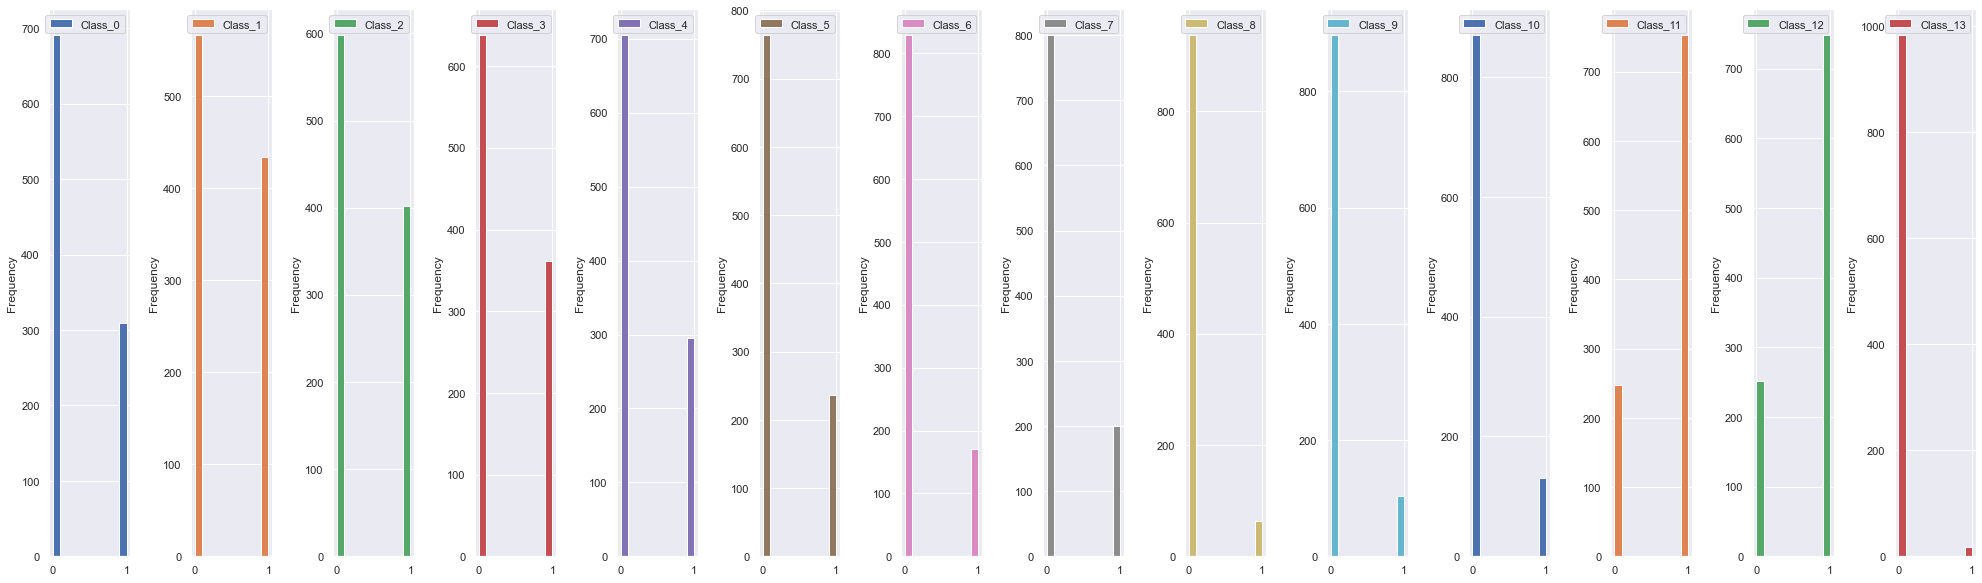

In [147]:
# Undestanding Distribution of Binary Variable Frequency 
sns.set(rc={'figure.figsize':(27.7,8.27)})
ax = master_target.plot.hist(subplots=True, legend=True, layout=(1,master_target.shape[1]))
plt.tight_layout()

##### Quick Observations: 
- One can see Classes 6, 8, 9 and 13  have sever imbalances in their target samples. 
- One can see the high correlation between certain classes illustrated here, as with Classes 11 and 12. 
    - The same observation applies for Classes 1, 2, 3 and 4


We do have sever inbalances between certain target sets, this is not good. Some form of balancing should take place. (In the original 2019 code I did not do this step and neither notice the inblance in the response variables. I still have to think of an efficient pipeline that can integrate to the already one I just modified that reduces the sample in a way that balances out the number of 1's and 0's). I will leave my thought process below.  

**A possible solution:**
First: Random Sampling from the larger dataset, into a sample around the same size of the smaller sample, but this actually doesn't work at all. Because for target no.13 there are too few elements from the smaller sample. 

Second: Perhaps imputing artificial data samples for the smaller sample size, or use penalized models for those specific target variables. I could also use another metric that doesn't overestimate when one of the sample is easier to predict than the other. 

## Feature Data Exploration 

#### Proportion of Nulls for Each Feature

All Data explorations are interested in the amount of nulls in a dataset. Missing data is a huge problem when training models, as certain models such as Random Forest or Decision trees might take nulls as information, and start segregating samples through nulls. 

Since we do not know what our data looks like, we must be aware of how many nulls are in the data, if the value is high, they should be imputed with some sort of imputaiton process ( there are simple and other more complicated ones)

In [152]:
# Create a  series for each feature column calculating percentages 
def create_table_highest_null_percentage(feature_table):
    """
    Function Creates a Sorted Table with a Percent Count of nulls for each column in a table 
    
    Parameter: the table with the columns you want to check nulls for. 
    Returns: a sorted table with a column for percent missing for each columns as rows. 
    
    """
    nulls_percents = feature_table.isnull().sum() * 100 / len(feature_table)
    table_percentage_nulls = pd.DataFrame(
        {'column_name': feature_table.columns,
        'percent_missing': nulls_percents}
    )

    # Which Features Have the Highest Percent of Missing Values ? 
    return table_percentage_nulls.sort_values(['percent_missing'], ascending=[False])

# Calling Function 
table_percentage_nulls = create_table_highest_null_percentage(master_training)
# Printing: Top 20 Features with Missing Values 
table_percentage_nulls.head(10)

,column_name,percent_missing
Feat_248,Feat_248,23.5
Feat_175,Feat_175,23.1
Feat_110,Feat_110,23.0
Feat_322,Feat_322,21.5
Feat_552,Feat_552,21.5
Feat_500,Feat_500,20.6
Feat_124,Feat_124,20.5
Feat_466,Feat_466,20.2
Feat_261,Feat_261,19.8
Feat_20,Feat_20,19.7


I just printed the features with  highest percentage of nulls, to see the highest level of nulls in the data sample. Apparently **23%** is the highest amount of nulls in the whole data set for features 248. 

I will be doing data Imputations for this dataset, just so we can have a complete dataset. Since we have no idea what the actual feature columns are, we can always benefit from getting more "complete" data rows from it.

##  Machine Learning: Data Transformation and Training  

### Splitting into Validation and Training Sets
Now that I have the data i the desired sample; I am going to split it into the different training ; evaluation and testing sets for the machine learning system. This is standard and anyone who works with training machine learning models understands the logic behind this step. 

One sample is used to train and cross validate and another uknown sample is used validate the performance of the previously trained sample. The results in accurracy of the prediction of the validation sample tells us how good the sample predicts with an unseen data sample. 

In [153]:
# Splitting Datasets for Validation, Training and Scoring 
X_train, X_val, y_train, y_val = train_test_split(master_training, master_target, test_size=0.33, random_state=0)

# Verifying the Shape of the Samples
print("Shape of Traing Sample",X_train.shape) # checking correct shape of elements 
print("Shape of Validation Samples", X_val.shape)
print("Shape of Target for Training Samples", y_train.shape)
print("Shape of Validation Target Samples",y_val.shape)

Shape of Traing Sample (670, 803)
Shape of Validation Samples (330, 803)
Shape of Target for Training Samples (670, 14)
Shape of Validation Target Samples (330, 14)


### Pre-Processing Data Points
So the dataset has a couple of issues with it:
- there are missing values
- there are noise created
- there are linear combinations and non-linear combinations of the previous features.

Now we have to select the best subset of our data, trying to deal with the previusly mentioned issues.

### Data Imputation 

As mentioned before while checking the amount of null values in the data sample. I am going to impute some data into the missing rows. 

I have chosen Median as the metric, since some data points can be very large in comparison to the other ones, and that can be skweeing the median towards larger values. In order to prevent such effect on the data, I am using "median" as the data imputation method. 

In [154]:
# Imputing Medians 
# Medians are better for values that might have larger continous value distributions 
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train = imputer.fit_transform(X_train) 
X_val= imputer.fit_transform(X_val) 
score_target  = imputer.fit_transform(score_target) 

# Array Management 
# We have to transform the elements back to dataframes, because the imputers returns 
# an array of the values and not a dataframe, with the column names 
# For the train set  change into dataframe 
X_train = pd.DataFrame(X_train)
X_train.columns= train.columns[1:804] 

# For validation  set  changing back to dataframe 
X_val = pd.DataFrame(X_val)
X_val.columns= train.columns[1:804]

# For the testing set  transforming into a dataframe with the proper columns names 
score_target = pd.DataFrame(score_target)
score_target.columns = train.columns[1:804]

### Scaling Data Points 

Data Scaling is when you transform the data such that the features are within a specific range. This is done in order to allow the data points to be in a standard distance range from each other. This allows models such as SVM and KNN to perform better when training. 

In [155]:
# Scaling the Data from the Training Samples and the Scoring 
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_val = standard_scaler.transform(X_val)
test_x= standard_scaler.transform(score_target)

### Dimension Reduction & Attribute Selection
Now we have to reduce the noise from the samples, this can be done by using dimension reduction techniques, which simply select the apprpiate variables ( regressor variables) to be utilized to predict a particular y variable ( we have 14 of them)

So this needs to be done for all different variables, in an iterative proccess. The Logistic Regression **LASSO L2 Method**, drops columns that are not "neccesary" or useful for predicting the target outcome. This method is a bit drastic here, and it will drop a lot of columns, specially for targets that are very imbalanced in terms of the binary outcome. 

Another method could be used is **PCA** Principal Component Analysis, in order to drop variables that it doesn't need. Tis method sometimes is undesired, as interpretability is loss after the data points are transformed. 

In [157]:
# Lasso Regression for Dimension Reduction Amongst 
# There is a consideration for the regressors having a linear relationship 
# between the regressor and the response, which would allow the L2 to be valid

# Logistic Regression 
reg =  LogisticRegression(random_state=0, solver='liblinear',penalty='l1',max_iter=20000) # lasso regression 

# Features Selected for Each Target TYpe
SelectedFeatures = []
for i in range(0,14): # for every target 1-14 
    
    # Fitting the Logistic Regression for Each Target Type 
    reg.fit(X_train, y_train.iloc[:,i])
    
    # Takign into consdieration each coefficient 
    coef = pd.Series(reg.coef_[0], index = master_training.columns)
    print("LogisticRegression with Lasso penalty picked for Class_" + str(i) + " " + str(sum(coef != 0)) + " optimal variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    
    # Create an array of Important Features  and append to list 
    imp_feat=coef.loc[coef!=0]
    SelectedFeatures.append(np.array(imp_feat.index))
    
    SelectedFeatures_DF = pd.DataFrame(np.array(imp_feat.index))
    
    # Storing the Datasets for Each Target 
    file_name  = "optimal_features_target_"+str(i)+".csv"
    path = "optimal_feature_lists_for_targets" + "/" + file_name
    SelectedFeatures_DF.to_csv(path, sep='\t',index=False)

LogisticRegression with Lasso penalty picked for Class_0 363 optimal variables and eliminated the other 440 variables
LogisticRegression with Lasso penalty picked for Class_1 367 optimal variables and eliminated the other 436 variables
LogisticRegression with Lasso penalty picked for Class_2 335 optimal variables and eliminated the other 468 variables
LogisticRegression with Lasso penalty picked for Class_3 327 optimal variables and eliminated the other 476 variables
LogisticRegression with Lasso penalty picked for Class_4 330 optimal variables and eliminated the other 473 variables
LogisticRegression with Lasso penalty picked for Class_5 302 optimal variables and eliminated the other 501 variables
LogisticRegression with Lasso penalty picked for Class_6 283 optimal variables and eliminated the other 520 variables
LogisticRegression with Lasso penalty picked for Class_7 307 optimal variables and eliminated the other 496 variables
LogisticRegression with Lasso penalty picked for Class_8

### Training Dataset Subsetting for Specific Targets 

In this part I am simply grabbing the datasets an transforming them into a subset, based on the previous dimension reduction. This happens in the final for loop of the code block. Most of the work here is transforming data back from arrays to Dataframe structures. 

In [158]:
# Subsetting Original Dataset with Optimal Features 
X_train = pd.DataFrame(X_train)
X_train.columns= train.columns[1:804] 

# For validation  set  changing back to dataframe 
X_val = pd.DataFrame(X_val)
X_val.columns= train.columns[1:804]

# For the testing set  transforming into a dataframe with the proper columns names 
score_target = pd.DataFrame(score_target)
score_target.columns = train.columns[1:804]

# For the targets Elements 
y_train = pd.DataFrame(y_train.values)
y_train.columns = train.columns[804:]

y_val = pd.DataFrame(y_val.values)
y_val.columns = train.columns[804:]


# Storing the New Dataframes based on Optimal Features 
new_x_train = []
new_x_val =[]
new_x_test = []

# Storing a list of Arrays with the Reduced** Features for each Target
for i in range(0,14):
    new_x_train.append(X_train[SelectedFeatures[i]])
    new_x_val.append(X_val[SelectedFeatures[i]])
    new_x_test.append(score_target[SelectedFeatures[i]])

## Model Iteration: Best Algorithm Search 

### Training Pipelines: 

Training pipelines are important. Scikitlearn does have pipeline modules incorporated into them, and they are fine, but I have found out through professional work that stakeholders, other data scientist and business is always interested in **flexibility** and mvp versions of trials for different options in terms of all the levers we can pull when playing around with datasets, as well as training and scoring with models. 

Because flexibility and iterations are key**, reproducibility and quick acess to said changes in an orderly manner is philosophy of code writing. I have created a small, very simply training pipeline below, that follows that philosophy.


#### Code Block Explanation: 

Usually this would be written in the code, but I think it is worth mentioning in the report blocks too. The code below has a dictionary with "model algorithms" as the keys. The valyes to each keys is another dictionary, detailing hyperparameter, each hyperparamter has a series type grid that can be iterated over. But why? 

We want to search for the best Hyperparameters for each model, when predicting, this is done though Hyperparameter tunning and GridSearch with crossvalidation methods. This all fine and dandy, the important aspect of the code is that I can choose, change and pick quickly which hyperparameter grids I want to play with in my training pipeline, through only changing this initial dictionary. 

For example, if the algorithm is not specified in this dictionary, it would not be tested and no models will be trained with said algorithm. So, in terms of visibility, anyone who is interested in seeing which models I am trying out you need only to check this dictionary, and if you are interested in looking at the parameters I tried out, you need only to see the parameters in the dictionary. **All in one place.**

In the following codeblocks, you will see more explanations to the code and the logic behind it, but most importantly this dictionary is now passed through a for loop that iterates over any combinations I want. The whole training process for all models, predictions and acurracies for all classes, and results acquisitions, all happen in one single block code, not all over the place. This is essential in large scale iterable projects. 



In [159]:
# Dictionaries and Variables: 
best_parameters_by_algorithm = {} # storing the best training parameters for each model
model_scores = {} # storing the scores for each model 
best_model_scores = {} # storing the best scores for each model 

# Dictionary with Grid Search Parameters for Each Model Algorithm 
# This is the work station
grid_search_parameters ={
    # Logistic Regression (Ridge Regression L2) Grid Search Parameters 
    "LR": {
        "C":np.power(10.0, np.arange(-10, 10)),
        "penalty":["l2"], "solver": ['newton-cg', "lbfgs"]
    }, 
    
    # Support Vector MachineGrid Search parameters 
    "SVM" : {
        "C": [0.1,1E2,1E5], 
        "gamma":[0.01,0.1,10, 40], "kernel":["rbf"]
    },
    
    # K Nearest Neighbors Search Parameters 
    "KNN" : {
        "n_neighbors":[3,4,5,6], 
             "weights":["uniform","distance"],"metric":["euclidean"]
    }, 
    
    # Decision Tree Grid Search Parameters 
    "DT" : {
        'max_depth':np.arange(1,15),
        'min_samples_leaf':[1, 5, 10, 20, 50, 100], "max_features": [30, 10, 12, 15]
    }, 
    
    # Random Forest Grid Search parameters 
    "RF" : {
        "n_estimators" : [500,1000],"max_features" : ["auto","sqrt"],
        "min_samples_split" : [30, 10, 12, 15]
    }, 
}    

In [160]:
# ------------------------ Training and Validation Models Pipeline  --------------------------- # 
#  The following code iterates over the Algorithms specified in grid_search_parameters,
#  that dictionary holds the grid search parameters for any algorithms that we will be 
#  comparing. If the algorithm is not a key in said dictionary, a model with said algoritm 
#  type, will not be trained and you will not get scores, nor optimal paramters for said model.
#  If you with to train a model with a specific algorithm, you must add it to the above 
#  dictionary. 
#
#  For the code below you only change the Model parameters related to the Cross Validation, 
#  the Number of jobs, and Accuraccy Metric for the models. If you desire to play with any 
#  hyperparameters, change only the dictionary in the code block above. 
#
#  Explanation for the Code: 
# 
#  The code below iterates over the algorithms used, and trains a model with each 
#  specific training set, established for each specific target. (We have reduced this training
#  sets through the dimension reduction done in the blocks above with the Lasso Regression) 
#  This sets are specific for each target, and hence when the model is trained and scored for 
#  a class or target (i), it is a costume dataset. 
#
#  The code below stores the scores for each model type for each target in a dictionary 
#  called model_scores* 
#
#  The code also stores the best grid search parameters ( or the parameters for the best mode)
#  in a dictionary named  best_parameters_by_algorithm*, the best scores are also stored in 
#  another dictionary called 
#--------------------------------------------------------------------------------------------- # 


# Training and Fitting Models in Specified in GridSearch Dictionary
for algorithm in grid_search_parameters: 
    
    # Checking for Model and Parameters to Use 
    if algorithm == "LR": 
        model = GridSearchCV(LogisticRegression(max_iter=20000),
                             grid_search_parameters[algorithm],cv=3)
    elif algorithm == "SVM": 
        model = GridSearchCV(SVC(max_iter = 20000), 
                             grid_search_parameters[algorithm],scoring="accuracy",cv=3,n_jobs=4,verbose=-1)
    elif algorithm == "KNN": 
        model = GridSearchCV(KNeighborsClassifier(),
                             grid_search_parameters[algorithm],verbose=1,cv = 3,n_jobs=1)
    elif algorithm == "DT":
        model = GridSearchCV(DecisionTreeClassifier(), 
                             grid_search_parameters[algorithm], scoring="accuracy", cv=3)
    elif algorithm == "RF": 
        model = GridSearchCV(RandomForestClassifier(),grid_search_parameters[algorithm],
                             n_jobs=-1, cv=3) 
    
    # Fitting for Each Target 0-14 for each Algorithm 
    model_best = []
    for i in range(0,14): 
    
        # Traing and Predict Models 
        model.fit(new_x_train[i],y_train.iloc[:,i])        
        val_predict = model.predict(new_x_val[i])
        score = accuracy_score(y_val.iloc[:,i],val_predict)        
        
        # Creating the Score Key for Each Algorithm and appending score for targets 
        if algorithm not in model_scores :
            model_scores[algorithm] = [score] 
        model_scores[algorithm].append(score)
        model_best.append(model)
        
        # Print out for LR 
        print("The Accuracy score for Class_" + str(i) + f" with {algorithm} model is " + str(score))
            
    if algorithm not in best_parameters_by_algorithm: 
        best_parameters_by_algorithm[algorithm] = model_best[i].best_estimator_
    if algorithm not in best_model_scores: 
        best_model_scores[algorithm] = model_best[i].best_score_
    

The Accuracy score for Class_0 with LR model is 0.5424242424242425
The Accuracy score for Class_1 with LR model is 0.5484848484848485
The Accuracy score for Class_2 with LR model is 0.5393939393939394
The Accuracy score for Class_3 with LR model is 0.5545454545454546
The Accuracy score for Class_4 with LR model is 0.6212121212121212
The Accuracy score for Class_5 with LR model is 0.6696969696969697
The Accuracy score for Class_6 with LR model is 0.7181818181818181
The Accuracy score for Class_7 with LR model is 0.7515151515151515
The Accuracy score for Class_8 with LR model is 0.8909090909090909
The Accuracy score for Class_9 with LR model is 0.8242424242424242
The Accuracy score for Class_10 with LR model is 0.7818181818181819
The Accuracy score for Class_11 with LR model is 0.7242424242424242
The Accuracy score for Class_12 with LR model is 0.6212121212121212


/Users/davidcampos/anaconda3/envs/hamilton/lib/python3.7/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidcampos/anaconda3/envs/hamilton/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


The Accuracy score for Class_13 with LR model is 0.9757575757575757


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    3.3s finished


The Accuracy score for Class_0 with SVM model is 0.703030303030303


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.4s finished


The Accuracy score for Class_1 with SVM model is 0.5969696969696969


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.2s finished


The Accuracy score for Class_2 with SVM model is 0.5878787878787879


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.1s finished


The Accuracy score for Class_3 with SVM model is 0.6424242424242425


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.2s finished


The Accuracy score for Class_4 with SVM model is 0.7090909090909091


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.1s finished


The Accuracy score for Class_5 with SVM model is 0.7333333333333333


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.0s finished


The Accuracy score for Class_6 with SVM model is 0.8121212121212121


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.0s finished


The Accuracy score for Class_7 with SVM model is 0.7757575757575758


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


The Accuracy score for Class_8 with SVM model is 0.9212121212121213


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    0.8s finished


The Accuracy score for Class_9 with SVM model is 0.9


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.0s finished


The Accuracy score for Class_10 with SVM model is 0.8666666666666667


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.2s finished


The Accuracy score for Class_11 with SVM model is 0.7515151515151515


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.1s finished


The Accuracy score for Class_12 with SVM model is 0.7454545454545455


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_13 with SVM model is 0.9787878787878788
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_0 with KNN model is 0.693939393939394
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_1 with KNN model is 0.5272727272727272
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_2 with KNN model is 0.6
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_3 with KNN model is 0.6363636363636364
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_4 with KNN model is 0.693939393939394
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_5 with KNN model is 0.7303030303030303
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_6 with KNN model is 0.7909090909090909
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_7 with KNN model is 0.7515151515151515
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_8 with KNN model is 0.9212121212121213
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_9 with KNN model is 0.8939393939393939
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_10 with KNN model is 0.8666666666666667
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_11 with KNN model is 0.696969696969697
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The Accuracy score for Class_12 with KNN model is 0.6878787878787879
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.4s finished


The Accuracy score for Class_13 with KNN model is 0.9787878787878788
The Accuracy score for Class_0 with DT model is 0.703030303030303
The Accuracy score for Class_1 with DT model is 0.5787878787878787
The Accuracy score for Class_2 with DT model is 0.6060606060606061
The Accuracy score for Class_3 with DT model is 0.5727272727272728
The Accuracy score for Class_4 with DT model is 0.6272727272727273
The Accuracy score for Class_5 with DT model is 0.7242424242424242
The Accuracy score for Class_6 with DT model is 0.8121212121212121
The Accuracy score for Class_7 with DT model is 0.7757575757575758
The Accuracy score for Class_8 with DT model is 0.9212121212121213
The Accuracy score for Class_9 with DT model is 0.9
The Accuracy score for Class_10 with DT model is 0.8666666666666667
The Accuracy score for Class_11 with DT model is 0.7484848484848485
The Accuracy score for Class_12 with DT model is 0.7454545454545455
The Accuracy score for Class_13 with DT model is 0.9727272727272728
The A

## Selecting Optimal Model for Each  Class/Target

Now that we have trained, cross validated and check the accuracy of our models  with every single target, we should have  matrix were we can see the Accuracy Score for each model in relationship to each target (14x5) Dataframe. 

This will alow us to choose the best column (Algorithm) for each row (Class/Target). This is very simple and it also allows us to see which class is the harders to predict or the easiest according to this particular accuracy metric.  

In [162]:
# Scores for Each Target for Each Algorithm 
DF = pd.DataFrame(model_scores)
rows_names = ["Class_"+ str(i) for i in range(0,15)]
DF.index = rows_names # esto crea la matrix 
print(DF)

                LR       SVM       KNN        DT        RF
Class_0   0.542424  0.703030  0.693939  0.703030  0.703030
Class_1   0.542424  0.703030  0.693939  0.703030  0.703030
Class_2   0.548485  0.596970  0.527273  0.578788  0.569697
Class_3   0.539394  0.587879  0.600000  0.606061  0.593939
Class_4   0.554545  0.642424  0.636364  0.572727  0.651515
Class_5   0.621212  0.709091  0.693939  0.627273  0.709091
Class_6   0.669697  0.733333  0.730303  0.724242  0.733333
Class_7   0.718182  0.812121  0.790909  0.812121  0.812121
Class_8   0.751515  0.775758  0.751515  0.775758  0.775758
Class_9   0.890909  0.921212  0.921212  0.921212  0.921212
Class_10  0.824242  0.900000  0.893939  0.900000  0.900000
Class_11  0.781818  0.866667  0.866667  0.866667  0.866667
Class_12  0.724242  0.751515  0.696970  0.748485  0.751515
Class_13  0.621212  0.745455  0.687879  0.745455  0.745455
Class_14  0.975758  0.978788  0.978788  0.972727  0.978788


**First Observation: Class Imbalances and Performance**
One can see that the classes where there was a high imbalance, tend to have higher acurracies, as predicted. This because the data is simply biased towards one sample, and a model has less difficulty discerning the differences, as it probably took the key characteristics of the smaller sample and simply ovefits based on them. 

**Second Observation: Model Comparison**
In the above matrix, one can see that there are models that simply performance better than others for certain classes, and other instances where most performen equally well or even tie out for certain classes. It would be interesting to see which models perform on average best across all targets. 


In [165]:
# Which Model Performens best on Average 
DF.mean()

LR     0.687071
SVM    0.761818
KNN    0.744242
DT     0.750505
RF     0.761010
dtype: float64

Well, one can see that Random Forest and SVM seem to have the best performances on average. But let us remember that we are interested in which model has the best performance for a particular target, so let us see for each target which is best.

We know tha Random Forests are powerfull algorithms, also SVM's, regardless of the class variable type which is binary in this case. They both perform very well.  But I am more intetested in having the Random Forest Method for the training than SVM's if they tie in a particular category. 

The following code block will prioritize Random Forests Over SVM models, if they tie in acurracy:  

In [176]:
# Since I want the IdMax in the next code block to choose RF's over SVM's when they tie
# I simply change the order of the columns so it chooses RF before SVM 
# I have dones this because I rather us Random Forests 
cols = DF.columns.tolist()
cols = cols[-1:] + cols[:-1]
DF = DF[cols]

In [178]:
# Selecting the Optimal Model for each CLass Blased on Scores
op_method = DF.idxmax(axis = 1, skipna = True)
print("The Optimal Algorithm Type for Each Class")
print(op_method)

The Optimal Algorithm Type for Each Class
Class_0      RF
Class_1      RF
Class_2     SVM
Class_3      DT
Class_4      RF
Class_5      RF
Class_6      RF
Class_7      RF
Class_8      RF
Class_9      RF
Class_10     RF
Class_11     RF
Class_12     RF
Class_13     RF
Class_14     RF
dtype: object


One can see for each Class/Target which is the best algorithm to use, in order to get the best accurracy. One can see the Random Forest Algorithm is considered the best. This is true for various reasons, that can be discussed in other Random Forest oriented projects. 

Before the change in order of the columns, most classes had the **SVM** algorithm as the optimal one, which means that most tied with **RF** as well, so the change was effective. Now we have **priotized the Random Forest Model** for prediction in the unlabaled prediction piece of this project. 

## Scoring with Optimal Models the Unlabaled Dataset 
For this last bit of code , we will use the optimal models to score the unlabeled dataset. What am I talking about? The submission sample that is turned in into Kaggle is a scored dataset, scored with the model you have obtained through your training, cross validaiton etc process. 

This model then predicts over an unlabeled dataset, meaning you have no idea how well your model is actually predicting, besides the previous training and validation acurracy measurements. Thisis why it is important to check your model's acurracy and perfomance, and reduce any possible biases, so when the model is presented with unseen data, it performs well.  This model is effective is then used to predict data more periodically, in other settings. But since this is for a competition this is the final prediction submission for each particular optimal model for each data sample. 

In [183]:
# If you were interested in checking out the Optimal Hyperparamters for each Element 
print("The Best Hyperparameter Combination for each Algorithm Type was:")
best_parameters_by_algorithm

The Best Hyperparameter Combination for each Algorithm Type was:


{'DT': DecisionTreeClassifier(max_depth=1, max_features=30),
 'KNN': KNeighborsClassifier(metric='euclidean', n_neighbors=3),
 'LR': LogisticRegression(C=1000000.0, max_iter=20000, solver='newton-cg'),
 'RF': RandomForestClassifier(min_samples_split=30, n_estimators=500),
 'SVM': SVC(C=0.1, gamma=0.01, max_iter=20000)}

In [184]:
#-------------------------------------- Scoring---------------------------------------––#
#
# This bit of the code uses the optimal method for each class, and a couple of things  
# it retrains the model with the complee dataset (Validation and training), and 
# after tha tit predicts over the unseen test sample, and this information is then 
# appended to a dataframe with the Class/target as columns and the result predictions 
# with the specific model as the series elements in the column. 
#
# The code selects hte optimal method from the op_method dataframe and predicts for its 
# corresponding class, which is iterated over. All of this information is storedin a 
# dataframe called "Results" (super creative).
#---------------------------------------------------------------------------------------# 
Results = pd.DataFrame()
for i in range(0,14):
    class_name  = "Class_"+ str(i)
    
    # Creating Datasets 
    Complete_x_train=[]
    Complete_y_train=[]
    Complete_x_train=pd.concat([new_x_train[i],new_x_val[i]])
    Complete_y_train=pd.concat([y_train.iloc[:,i],y_val.iloc[:,i]])
    
    # Fitting Optimal Models to the Unlabeled Dataset Targets 
    for algorithm in best_parameters_by_algorithm: 
        if op_method[i] == algorithm:
            best_parameters_by_algorithm[algorithm].fit(Complete_x_train,Complete_y_train)
            test_predict = best_parameters_by_algorithm[algorithm].predict(new_x_test[i])
            Results[class_name]= test_predict

In [188]:
# The Result is a dataset with the scored columns 
# for each target, with the best model for each target, 
# trained with the best hyper parameters in terms of performance 
# each one of those models for each target 
Results.to_csv('data/kaggle_submission_2020.csv', index= True)
Results

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In this final block we get a results dataframe, that is then stored and uploaded to the Kaggle Submission portal , in order to be compared and checked for accuracy, depending on how good were the predictions, I could go up or down in the rankings for the competition. 